# DSPM - HW#2
Name: Sudheeshna Sampath

Andrew ID: sudheess

In [1]:
#!pip install plotly==2.7.0
#conda install -c https://conda.anaconda.org/plotly plotly
#!conda install -c plotly plotly_express
!pip install plotly==5.6.0

  Using cached plotly-5.6.0-py2.py3-none-any.whl (27.7 MB)
  Attempting uninstall: plotly
    Found existing installation: plotly 2.7.0
    Uninstalling plotly-2.7.0:
      Successfully uninstalled plotly-2.7.0


In [32]:
#load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import plotly.express as px

# 1) EDA

In [33]:
#read input file
df_full = pd.read_csv("C:\\Users\\sudhe\\Desktop\\Spring '22\\DSPM\\HW2\\analytic_data2021.csv", skiprows=[1])

In [34]:
#Keep only necessary columns - dimenstions and raw_values of health features and outcomes
keep_cols=['State Abbreviation', 'Name', 'Release Year','County Ranked (Yes=1/No=0)']
for i in df_full.columns:
    if (('Code' in i) | ('raw' in i)):
        keep_cols.append(i)
        
df = df_full[keep_cols]

In [35]:
#Find the number of missing values per column
miss_val = df.isnull().sum()
print("Column         # Missing values")
for key,value in miss_val.iteritems():
    if(value>0):
        print(key,":",value)

Column         # Missing values
County Ranked (Yes=1/No=0) : 52
Premature death raw value : 61
Low birthweight raw value : 105
Food environment index raw value : 19
Access to exercise opportunities raw value : 6
Alcohol-impaired driving deaths raw value : 34
Sexually transmitted infections raw value : 154
Teen births raw value : 173
Uninsured raw value : 1
Primary care physicians raw value : 150
Dentists raw value : 89
Mental health providers raw value : 221
Preventable hospital stays raw value : 45
Mammography screening raw value : 20
Flu vaccinations raw value : 18
Unemployment raw value : 1
Children in poverty raw value : 1
Income inequality raw value : 1
Children in single-parent households raw value : 1
Violent crime raw value : 191
Injury deaths raw value : 110
Air pollution - particulate matter raw value : 26
Drinking water violations raw value : 45
Life expectancy raw value : 69
Premature age-adjusted mortality raw value : 61
Child mortality raw value : 1257
Infant mortality ra

In [36]:
#Drop columns with more than 80% null values
percent_null = len(df) * .80
df = df.dropna(thresh=percent_null, axis=1)

In [37]:
#Create list of relevant Health Outcomes
health_outcomes = ['Premature death raw value', 'Poor or fair health raw value','Poor physical health days raw value',
              'Poor mental health days raw value', 'Low birthweight raw value','Life expectancy raw value',
               'Premature age-adjusted mortality raw value','Frequent physical distress raw value','Frequent mental distress raw value', 'Diabetes prevalence raw value']

#Create list of relevant health factors
df_temp = df
df_temp = df_temp.drop(health_outcomes,axis=1)
df_temp =df_temp.drop(['State Abbreviation', 'Name', 'Release Year','County Ranked (Yes=1/No=0)', 'State FIPS Code',
                  'County FIPS Code','5-digit FIPS Code'],axis=1)

health_factors = list(df_temp.columns)

In [38]:
#Remove outliers (values that lie outside 1.5 IQR) from features
Q1 = df[health_factors].quantile(0.25)
Q3 = df[health_factors].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[health_factors] < (Q1 - 1.5 * IQR)) |(df[health_factors] > (Q3 + 1.5 * IQR))).all(axis=1)]

In [39]:
#Remove state and national level data
df = df[df['County Ranked (Yes=1/No=0)'].isna()==False]

#replace missing values for measure columns with column mean except for County Ranked (Yes=1/No=0)
df= df.fillna(df.mean())

In [40]:
df.shape

(3142, 76)

In [41]:
#Keep only required health feature and outcome columns to find correlation between them
df_measurements = df.drop(['State Abbreviation', 'Name', 'Release Year','County Ranked (Yes=1/No=0)',
                           'State FIPS Code', 'County FIPS Code','5-digit FIPS Code'],axis=1)

<AxesSubplot:>

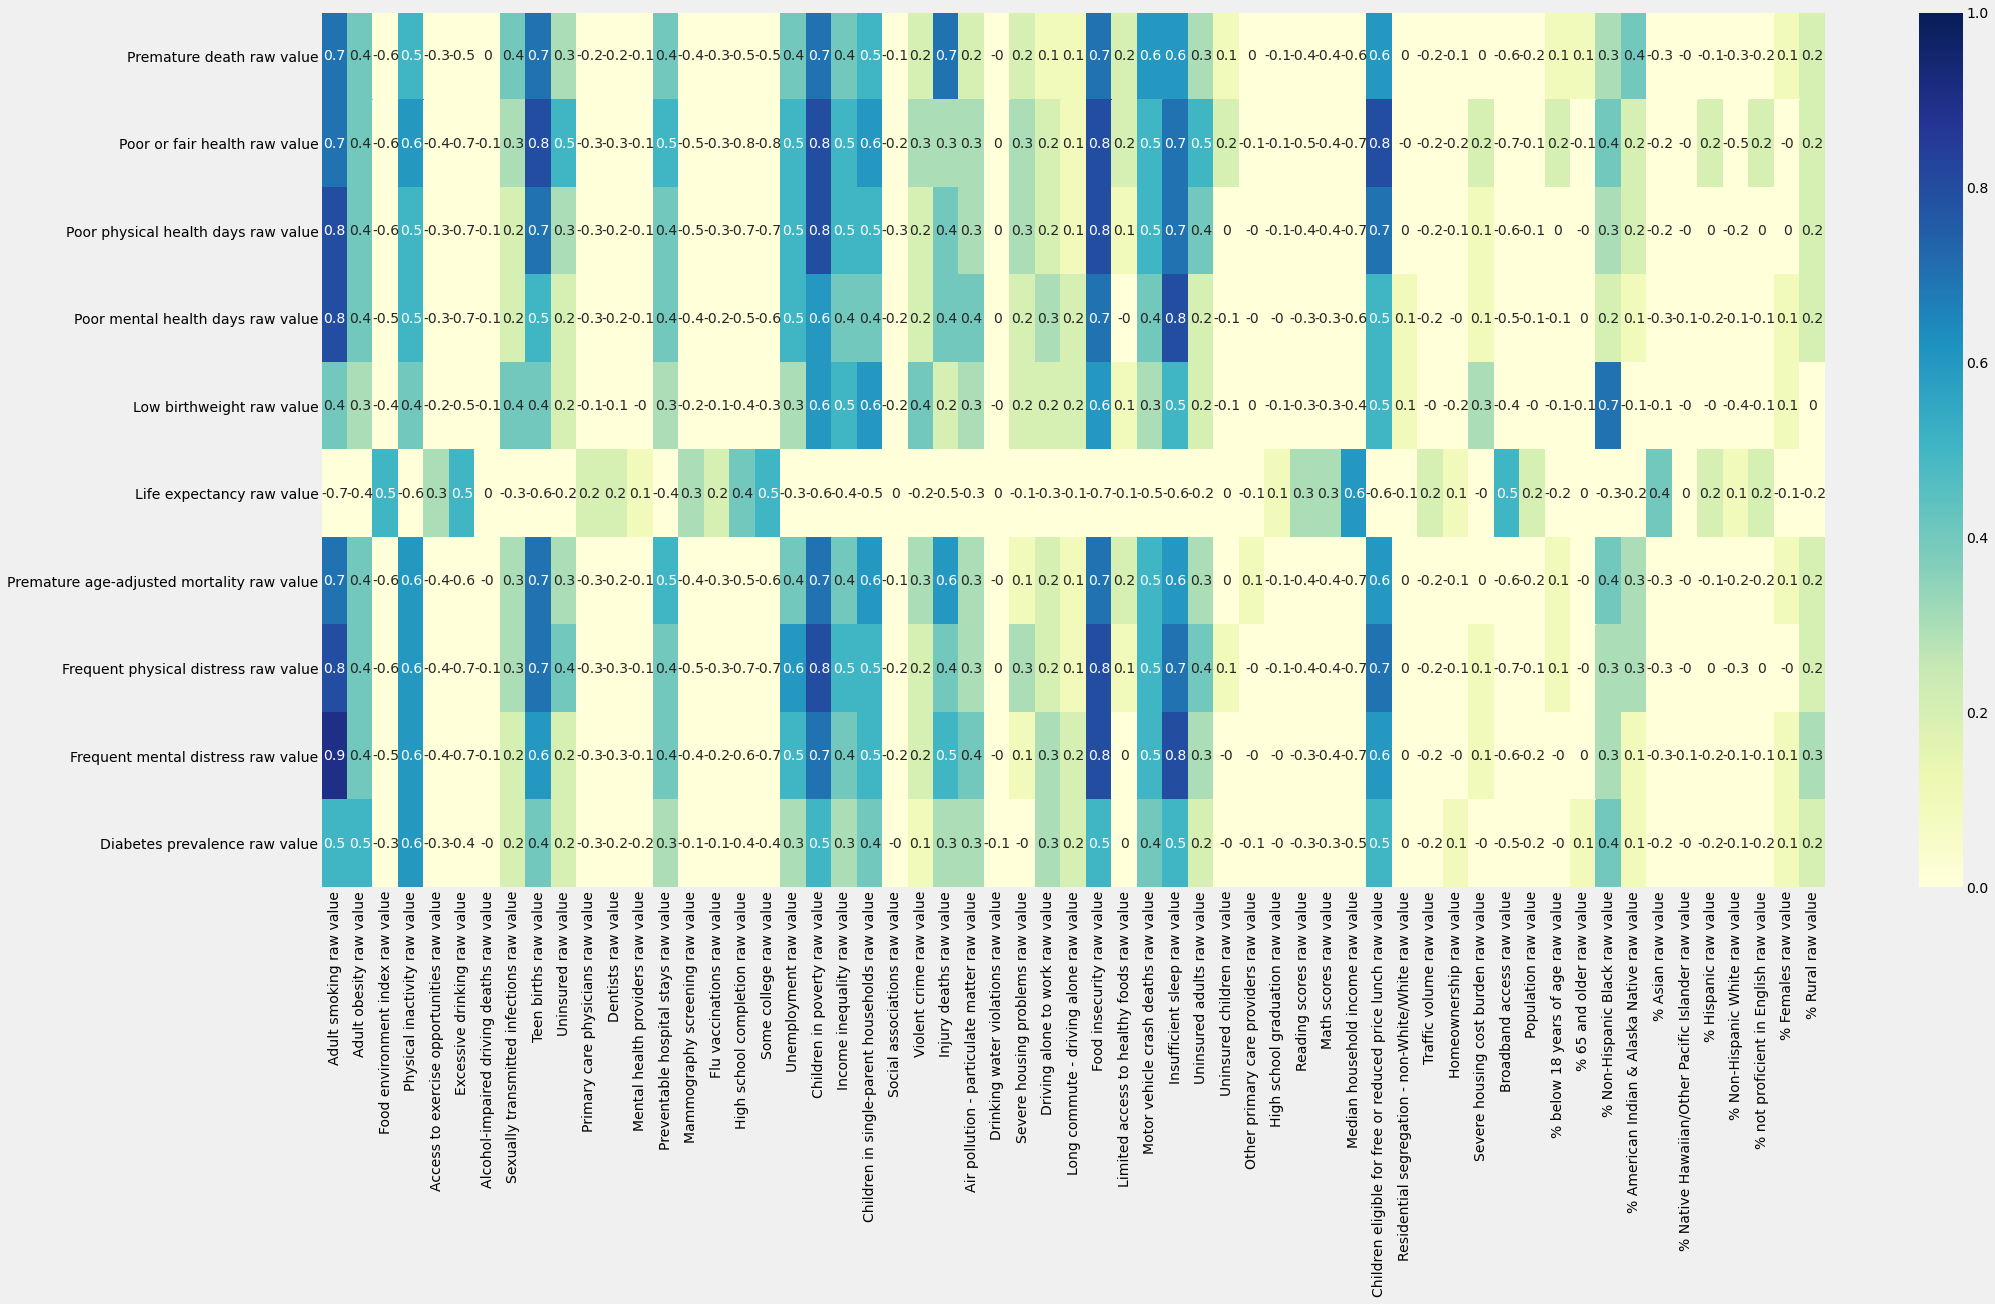

In [75]:
#Finding the correlations between the health features and outcomes through heat map
plt.figure(figsize=(30, 15))
df_Corr= df.corr()
df_Corr = df_Corr[health_factors]
df_Corr = df_Corr.loc[health_outcomes]
sns.heatmap(round(df_Corr,1),vmin=0, vmax=1,annot=True,square=False,cmap="YlGnBu")

In [43]:
#Finding features and outcomes that have highest correlation
c = df_Corr.abs()
s = c.unstack().sort_values().drop_duplicates()
s = s.loc[s.values>0.7]
print("Health Factors: \t\t\t\t Health Outcomes: \t\t\t\t  Correlation:")
print()
print(s)

Health Factors: 				 Health Outcomes: 				  Correlation:

Children in poverty raw value                                Frequent mental distress raw value            0.705138
Broadband access raw value                                   Poor or fair health raw value                 0.706635
Children eligible for free or reduced price lunch raw value  Frequent physical distress raw value          0.709811
Teen births raw value                                        Premature age-adjusted mortality raw value    0.710011
Adult smoking raw value                                      Poor or fair health raw value                 0.712181
Teen births raw value                                        Frequent physical distress raw value          0.715152
Excessive drinking raw value                                 Poor or fair health raw value                 0.715287
Median household income raw value                            Frequent physical distress raw value          0.720072
Food insecurit

The above show health features with notable correlation with the output health variables. Moving forward, we will use these features for our supervised and unsupervised learning model.

In [15]:
#Keeping only relevant factors to find clusters
relevant_factors = s.index.get_level_values(0).unique()
irrelevant_factors = set(health_factors) - set(s.index.get_level_values(0).unique())
df_measurements_new = df_measurements.drop(irrelevant_factors,axis=1)

# 2) Clustering

In [44]:
#Standardizing features for pre-processing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_vectorized = scaler.fit_transform(df_measurements_new)

In [45]:
#Finding number of clusters
from sklearn.cluster import KMeans
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k,  random_state=0)
    kmeans.fit(X_vectorized)
    sse.append(kmeans.inertia_)

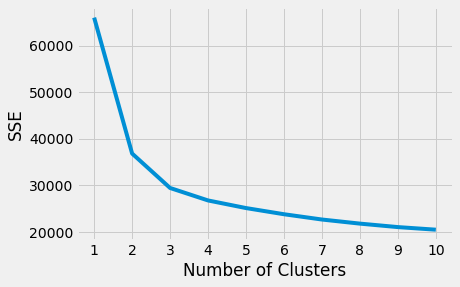

In [46]:
#Finding elbow point to find the most appropriate number of clusters
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The elbow point from the above residual sum of squares graph is 3. So we can proceed with using 3 clusters 

In [47]:
#Getting clusters from Kmeans Clustering methods
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_vectorized)
labels  = kmeans.predict(X_vectorized) 

df['Cluster'] = labels+1

for i in range(3):
    print("Cluster ",i+1,": ",len(labels[labels==i]))

Cluster  1 :  776
Cluster  2 :  1033
Cluster  3 :  1333


In [48]:
#Plot clusters of counties at state level
fig = px.choropleth(df,
                    locations='State Abbreviation',
                    color='Cluster',
                    color_continuous_scale='spectral_r',
                    locationmode='USA-states',
                    scope='usa')
fig.show()

The above shows note worthy groupings of health outcomes and features represented at a county-state level. 
Counties in most of the southern states are in one cluster, while counties in most west coast and north-east are in another cluster. 
Counties in most northern states belong to a different cluster. 

In [65]:
#Dataframe containing different county-wise clusters
df_county_cluster = df[['Name','Cluster']]
df_county_cluster = df_county_cluster.drop_duplicates()

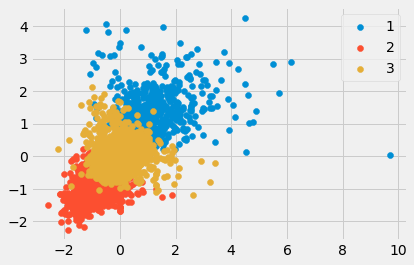

In [66]:
#Getting unique labels
labelsUnique = np.unique(labels)
 
#plotting the clusters in scatter plot:
for i in labelsUnique:
    plt.scatter(X_vectorized[labels == i , 0] , X_vectorized[labels == i , 1] , label = i+1)
plt.legend()
plt.show()

In [67]:
#Finding features that have highest correlation with
s2 = c.unstack().sort_values().drop_duplicates()
s2 = s2[s2.index.get_level_values(1)=='Premature death raw value']
s2 = s2[s2.values>0.5]
pd_Health_factors = s2.index.get_level_values(0)

To predict Premature death, we keep health features that are most correlated to the premature death raw value column

# 3) Predictive Modelling

In [68]:
#Standardizing features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_features_vectorized = scaler.fit_transform(df[pd_Health_factors])

In [69]:
#Split the dataset into test and train 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_features_vectorized, df['Premature death raw value']/100000, test_size=0.25, random_state=0)

Trying Random Forest Regression and K-Nearest Neigbour Regression models to see which one yields higher accuracy for predicting Premature death:

In [58]:
##Using KNN Regessor model to predict Premature Death raw values

#Find best parameter using GridSearchCV
random_grid_rf = {'max_features': ['auto', 'sqrt'],'min_samples_split': [2, 5, 10]}

rf = RandomForestRegressor()
rf_random = GridSearchCV(estimator=rf, param_grid=random_grid_rf, cv= 5)
rf_params = rf_random.fit(X_train, Y_train)
rf_params.best_params_

{'max_features': 'auto', 'min_samples_split': 2}

In [59]:
##fit model in RandomForestRegressor and predict test data to calc model accuracy
rf_model = RandomForestRegressor(min_samples_split= 10)
rf_model.fit(X_train, Y_train)
rf_predictions = rf_model.predict(X_test)
rf_errors = abs(rf_predictions - Y_test)
rf_mape = 100 * np.mean(rf_errors / Y_test)
rf_accuracy = 100 - rf_mape

print('Random Forest Regressor Model Performance')
print('Average Error: {:0.2f}'.format(np.mean(rf_errors)))
print('Accuracy = {:0.2f}%.'.format(rf_accuracy))

Random Forest Regressor Model Performance
Average Error: 0.01
Accuracy = 88.93%.


In [60]:
##Using KNN Regessor model to predict Premature Death raw values

#Find best parameter using GridSearchCV
knn = KNeighborsRegressor()
random_grid_knn = dict(n_neighbors=list(range(1, 20)))

knn_random = GridSearchCV(estimator = knn, param_grid = random_grid_knn, cv=5)

knn_params = knn_random.fit(X_train, Y_train)
knn_params.best_params_

{'n_neighbors': 10}

In [61]:
##fit model in KNeighborsRegressor and predict test data to calc model accuracy
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_train, Y_train)
knn_predictions = knn_model.predict(X_test)
knn_errors = abs(knn_predictions - Y_test)
knn_mape = 100 * np.mean(knn_errors / Y_test)
knn_accuracy = 100 - knn_mape

print('Random Forest Regressor Model Performance')
print('Average Error: {:0.2f}'.format(np.mean(knn_errors)))
print('Accuracy = {:0.2f}%.'.format(knn_accuracy))

Random Forest Regressor Model Performance
Average Error: 0.01
Accuracy = 88.55%.


From above, we see that the Random Forrest Regessor Model is better than KNN Regessor Model as it yields slightly higher accuracy

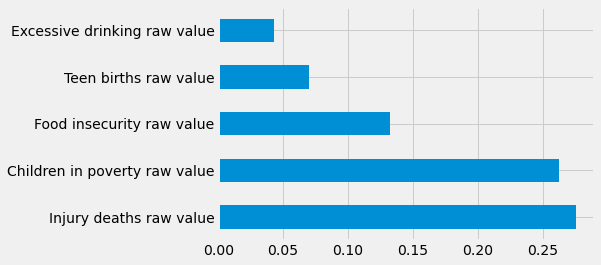

In [70]:
#plot graph of feature importances and pick top 5 features out that predict Premature Death
health_feat_imp = pd.Series(rf_model.feature_importances_, index=df[pd_Health_factors].columns)
health_feat_imp.nlargest(5).plot(kind='barh')
plt.show()

Top 5 health factors affecting Premature Death are Injury Deaths, Children in Poverty, Food Insecurity, Teen Births and Excessive Drinking 

# 4) Allegheny County Analysis

In [63]:
#Filter only for Allegheny County and check for high raw values
df_ac = df[df['Name']=='Allegheny County'] 
df_ac = df_ac[['Premature death raw value','Injury deaths raw value','Children in poverty raw value', 
        'Food insecurity raw value', 'Teen births raw value','Excessive drinking raw value']]
df_final

,Premature death raw value,Injury deaths raw value,Children in poverty raw value,Food insecurity raw value,Teen births raw value,Excessive drinking raw value
2285,7750.055122,104.63952,0.141,0.106,12.0505,0.21926


In [87]:
#Mean of each column with all counties included
df_overall = df[['Premature death raw value','Injury deaths raw value','Children in poverty raw value', 
        'Food insecurity raw value', 'Teen births raw value','Excessive drinking raw value']]
df_overall.describe(include='all').loc['mean']

Premature death raw value        8499.573851
Injury deaths raw value            89.050313
Children in poverty raw value       0.199670
Food insecurity raw value           0.131954
Teen births raw value              27.947167
Excessive drinking raw value        0.190953
Name: mean, dtype: float64

Compared to the national average of each of the top 5 selected health factors, Allegheny County's Teen births, Children in Poverty & Food insecurity seems to be higher. Allegheny County can focus its efforts towards reducing these three factors, particularly Teen Births to reduce premature deaths in the county